# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
pd.set_option('display.max_rows', 40)


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
def categorize(df, col, nbins=10, quantiles=True):
    '''
    categorize continuous variable
    '''
    
    df1=df.copy()
    if quantiles:
        
        # create bin values based on quantiles
        quantiles = [df[col].quantile(0.1*i) for i in range(nbins)]
        bins=np.unique(quantiles)
        bins = np.append(-np.inf, bins)
        bins = np.append(bins, np.inf)
        categorized = pd.cut(df1[col], bins=bins, right=True, labels=[i for i in range(len(bins)-1)], include_lowest=True)
    
        
    else:
        
        #create uniform bins values
        col_min, col_max = df[col].min(), df[col].max() 
        bins = [col_min+(col_max-col_min)/nbins*i for i in range(nbins)]
        bins = np.unique(bins)
        bins = np.append(-np.inf, bins)
        bins = np.append(bins, np.inf)
        categorized = pd.cut(df1[col], bins=bins, right=True, labels=[i for i in range(len(bins)-1)])
    col=col+'_categorized'
    df1[col] = categorized
    return df1

In [4]:
# check what are the types of channels
chans = set()
for i, row in portfolio.iterrows():
    chans.update(set(row.channels))
chans

{'email', 'mobile', 'social', 'web'}

In [5]:
# transcript[transcript.event == 'offer received'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='offer viewed'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='offer completed'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='transaction'].value.apply(lambda x: x.keys()).value_counts()

# 1) Data cleaning

In [6]:
# Lets unpack the key in value from value column into separate columns
transcript['key'] = transcript.value.apply(lambda x: list(x.keys())[0])
transcript['val'] = transcript.value.apply(lambda x: list(x.values())[0])
transcript.drop('value', axis=1, inplace=True)

In [7]:
transcript.shape

(306534, 5)

0) Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

1) you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. 

2) you could build a model that predicts whether or not someone will respond to an offer.

3) Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [8]:
# merge transcript with profile

transcript_profile = pd.merge(transcript, profile, right_on = 'id', left_on ='person')

In [9]:
transcript_profile.head()

,person,event,time,key,val,gender,age,id,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,amount,19.89,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,amount,17.78,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0


In [10]:
transcript[transcript.event=='offer received'].groupby(['person', 'val']).count()

event  \
person                           val                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
...                                                                  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 2906b810c7d4411798c6938adc9daaa5      3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   

                                                                   time  key  
person                           val                                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     1    1  
                                 3f207df678b143eea3cee63160fa8bed     1    1  
                                 5a8bc65990b245e5a138643cd4eb9837     1    1  
                                 f19421c1d4aa40978ebb69ca19b0e20d     1    1  
                                 fafdcd668e3743c1bb461111dcafc2a4     1    1  
...                                                                 ...  ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d     2    2  
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7     1    1  
                                 2906b810c7d4411798c6938adc9daaa5     3    3  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     1    1  
                                 fafdcd668e3743c1bb461111dcafc2a4     1    1  

[63288 rows x 3 columns]

In [11]:
# conclusion: one person may receive the same offer a few times

## Create a column which indicates whether an offer sent to a given customer was successful or failure

In [12]:
# # delete tarnsaction amount from the dataset as we will not analyse the amount spent

# df0 = transcript[transcript.event != 'transaction']

# # create dataframe grouped by person and offer send to this person. Concatenate all the events related
# # to an offer and person into one row
# df1 = pd.DataFrame(df0.groupby(['person', 'val'])['event'].agg(list))

In [13]:
# df1

In [14]:
# We need to merge with transcript with portfolio table because we will treat informational offers separately

## Approach to informational offers

In [15]:
# try different approach for checking successful columns

transcript_portfolio = pd.merge(transcript, portfolio, how='outer', left_on='val', right_on = 'id')

In [16]:
# we consider only if the person applied the given informational offer
# we do not take into consideration how many times this offer was sent to that customer
# we will analyse only if after some time the customer responded to the offer

In [17]:
# select only informational offers

inf_offers = transcript_portfolio[transcript_portfolio['offer_type'] == 'informational']
# select only transactions of a given customer
transactions = transcript_portfolio[transcript_portfolio.event=='transaction']

In [18]:
transactions.drop(['event', 'key','reward','channels','difficulty','duration','offer_type', 'id'], axis=1, inplace=True)
transactions.rename(columns={"val": "amount", "time": "transaction_time"}, inplace=True)
inf_offers.drop(['key',  'channels', 'offer_type', 'id'], axis=1, inplace=True)
inf_offers.rename(columns={"val":"offer_id", "time":"offer_time"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
transactions

,person,transaction_time,amount
167581,02c083884c7d45b39cc68e1314fec56c,0,0.83
167582,e1251ca419a84273a8a974fe61d3c69e,12,0.83
167583,b94c7601b17b41609daa2e3e56c3f53d,24,0.83
167584,8c21762e5c1c4ea881f6a9989116b058,30,0.83
167585,7e70232d747043f1ae50f3bb41e32e91,30,0.83
...,...,...,...
306529,76018bc0dfd64ccc8f2e7959bf627ba7,708,290.93
306530,d81ed5c788bd49ec803bec849c64dbba,708,43.91
306531,a0f4c1aafeda4398a7afe66c37caf416,714,685.07
306532,692e3eaba5854ad5bbdd51d241647830,714,405.04


In [20]:
# We need to sort the tables by person and time the transaction was made
transactions.sort_values(by=['person', 'transaction_time'], inplace=True)
inf_offers.sort_values(by=['person', 'offer_time'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
transactions = transactions.groupby(['person']).agg(list).reset_index()
customer_offers = inf_offers.groupby(['person', 'offer_id']).agg(list).reset_index()

In [22]:
transactions.head(3)

,person,transaction_time,amount
0,0009655768c64bdeb2e877511632db8f,"[228, 414, 528, 552, 576, 660, 690, 696]","[22.16, 8.57, 14.11, 13.56, 10.27, 12.36, 28.1..."
1,00116118485d4dfda04fdbaba9a87b5c,"[294, 456, 474]","[0.7000000000000001, 0.2, 3.19]"
2,0011e0d4e6b944f998e987f904e8c1e5,"[132, 252, 576, 642, 654]","[13.49, 11.93, 22.05, 23.03, 8.96]"


In [23]:
customer_offers.head(3)

,person,offer_id,event,offer_time,reward,difficulty,duration
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[336, 372]","[0.0, 0.0]","[0.0, 0.0]","[4.0, 4.0]"
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]","[168, 192]","[0.0, 0.0]","[0.0, 0.0]","[3.0, 3.0]"
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[0, 6]","[0.0, 0.0]","[0.0, 0.0]","[4.0, 4.0]"


In [24]:
# Now let us merge transaction dataframe with the offers dataframe
transactions_offer = pd.merge(customer_offers, transactions, how='left', on='person')

In [25]:
transactions_offer.head(2)

,person,offer_id,event,offer_time,reward,difficulty,duration,transaction_time,amount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[336, 372]","[0.0, 0.0]","[0.0, 0.0]","[4.0, 4.0]","[228, 414, 528, 552, 576, 660, 690, 696]","[22.16, 8.57, 14.11, 13.56, 10.27, 12.36, 28.1..."
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]","[168, 192]","[0.0, 0.0]","[0.0, 0.0]","[3.0, 3.0]","[228, 414, 528, 552, 576, 660, 690, 696]","[22.16, 8.57, 14.11, 13.56, 10.27, 12.36, 28.1..."


In [26]:
# merged.event.value_counts()

In [27]:
# for each customer and offer check if this offer was successful
# assume if offer was received 2 times and then viewed assume the latter one was viewed and previous is not successful

transactions_offer['successful'] = 0
transactions_offer['delete'] = 0
# merged['successful_all'] = 0
# merged['successful_all'] = merged['successful_all'].astype('object')
for i, row in transactions_offer.iterrows():
    
    # get locations of when the offer was viewed in the event list
    # assume from that time the offer starts being activated
    event = row['event']
    locs = [x for x in range(len(event)) if event[x]=='offer viewed']
    
    # suc = [0 for x in range(len(event)) if event[x]=='offer received'] 
    # check if there were moments when the offer was viewed
    # otherwise the offer was not completed
    if len(locs)>=1:
        
        # check if there were any transactions made
        # otherwise the offer couldn't be completed
        if not np.isnan(row['transaction_time']).all():
            transaction_time = row['transaction_time']

            # for each' offer view' check if it was successful
            for loc in locs:
                offer_start = row['offer_time'][loc]
                offer_duration = row['duration'][loc]
                #check if any transaction satisfies an offer
                # time 

                for j in transaction_time:
                    if j > offer_start and j-offer_start > offer_duration:
                        row['successful']=1
                        transactions_offer.loc[i, 'successful'] = 1
                        # the offer that was received just before it was viewed was valid and successful
                        # suc[loc-1] = 1
                        # merged.at[i, 'successful_all'] = list(suc)
    else:
        transactions_offer.loc[i, 'delete'] = 1
# we assume that if a customer saw an offer and did not complete it then the offer is failed
# if a customer didn't see an offer then we should delete this observation as it doesn't bing any useful information

        

In [28]:
# delete not needed observations
informational_offers = transactions_offer[transactions_offer.delete==0]

In [29]:
# delete unwanted columns
informational_offers.drop(columns=['event', 'offer_time', 'reward', 'difficulty', 'duration', 'transaction_time', 'amount','delete'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
informational_offers.head(2)

,person,offer_id,successful
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1


## Discount and bogo offers

In [31]:
# customer_transactions_list = tp.groupby(['person', 'val']).agg(list)

In [32]:
dis_bogo_offers = transcript_portfolio[np.logical_or(transcript_portfolio['offer_type'] == 'bogo', transcript_portfolio['offer_type'] == 'discount')]

In [33]:
dis_bogo_offers = dis_bogo_offers.sort_values(by=['person','time'])

In [34]:
dis_bogo_offers.event.unique()

array(['offer received', 'offer completed', 'offer viewed'], dtype=object)

In [35]:
# delete tarnsaction amount from the dataset as we will not analyse the the amount spent

# df0 = transcript[transcript.event != 'transaction']

# create dataframe grouped by person and offer send to this person. Concatenate all the events related
# to an offer and person into one row
dis_bogo = pd.DataFrame(dis_bogo_offers.groupby(['person', 'val']).agg(list))

In [36]:
dis_bogo.head(2)

event  \
person                           val                                                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                [offer received, offer completed]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [offer received, offer completed, offer viewed]   

                                                                              time  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [576, 576]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [408, 414, 456]   

                                                                                              key  \
person                           val                                                                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5            [offer id, offer_id]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [offer id, offer_id, offer id]   

                                                                            reward  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [2.0, 2.0]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [5.0, 5.0, 5.0]   

                                                                                                            channels  \
person                           val                                                                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [[web, email, mobile], [web, email, mobile]]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [[web, email, mobile, social], [web, email, mo...   

                                                                        difficulty  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     [10.0, 10.0]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [5.0, 5.0, 5.0]   

                                                                          duration  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [7.0, 7.0]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [5.0, 5.0, 5.0]   

                                                                             offer_type  \
person                           val                                                      
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  [discount, discount]   
                                 f19421c1d4aa40978ebb69ca19b0e20d    [bogo, bogo, bogo]   

                                                                                                                  id  
person                           val                                                                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  [2906b810c7d4411798c6938adc9daaa5, 2906b810c7d...  
                                 f19421c1d4aa40978ebb69ca19b0e20d  [f19421c1d4aa40978ebb69ca19b0e20d, f19421c1d4a...

In [37]:
# create column indicating whether an offer was successful or not

dis_bogo['success'] = 0
# we should treat informational offers separately
for i, row in dis_bogo.iterrows():

    # was the offer viewed and completed?
    if 'offer viewed' in row.event and 'offer completed' in row.event: 
        # was it viewed before completion? otherwise the offer is not successful 
        # check if the last 'offer completed' was after the first 'offer viewed'
        # then the customer at least once completed the offer after viewing it
        last_copleted = [idx for idx in range(len(row.event)) if row.event[idx]=='offer completed'][-1]
        first_viewed = [idx for idx in range(len(row.event)) if row.event[idx]=='offer viewed'][0]
        if last_copleted > first_viewed:
            # then the offer was successful
            dis_bogo.loc[i, 'success'] = 1
            
# create column indicating whether an offer was failure or not

dis_bogo.reset_index(inplace=True)
dis_bogo['failure'] = 0

for i, row in dis_bogo.iterrows():
    # was the offer viewed and not completed ? then the offer was a failure
    if 'offer viewed' in row.event and 'offer completed' not in row.event: 
        # then the offer failed
        dis_bogo.loc[i, 'failure'] = 1
    # was the last 'offer completed' event before last offer viewed? If yes then we cannot conclude if the offer was successful 
    

In [38]:
# create column indicating whether an offer was successful or not

# df1['success'] = 0
# # we should treat informational offers separately
# for i, row in df1.iterrows():

#     # was the offer viewed and completed?
#     if 'offer viewed' in row.event and 'offer completed' in row.event: 
#         # was it viewed before completion? 
#         # check the if position of 'offer viewed' is lower than position of 'offer completed' in the list
#         if np.where(row.event == 'offer viewed')[0][0] < np.where(row.event == 'offer completed')[0][0]:
#             # the the offer was successful
#             df1.loc[i, 'success'] = 1

In [39]:
# how many offers do we have in the dataset which were neither viewed nor received
print(np.logical_and(dis_bogo.success==0, dis_bogo.failure==0).sum())
print(np.logical_and(dis_bogo.success==0, dis_bogo.failure==1).sum())
print(np.logical_and(dis_bogo.success==1, dis_bogo.failure==0).sum())
print(np.logical_and(dis_bogo.success==1, dis_bogo.failure==1).sum())

13899
15366
21372
0


In [40]:
# conclusion:
# there are bogo and discount offers which were neither failure nor successful.
# They do not give any usefull information as we do not know e.g. whether someone would
# complete the offer if he saw it before
# thus we will delete it

In [41]:
# those may be offers which were received but not viewed, thus we will not use those offers

In [42]:
dis_bogo = dis_bogo[np.logical_or(dis_bogo.success==1, dis_bogo.failure==1)]

In [43]:
# lets drop failure column as now failure information is contained in the success column
dis_bogo.drop(['failure'], axis=1, inplace=True)

In [44]:
# lets delete not needed columns

dis_bogo.drop(columns=['event','time', 'key', 'reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], inplace=True)

In [45]:
dis_bogo.rename(columns={"val":"offer_id", "success": "successful"}, inplace=True)

In [46]:
dis_bogo.head(2)

,person,offer_id,successful
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1


In [47]:
informational_offers.head(2)

,person,offer_id,successful
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1


In [48]:
# we need to concatenate the above two tables
offer_success = pd.concat([dis_bogo, informational_offers])

In [49]:
offer_success.head(2)

,person,offer_id,successful
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1


In [50]:
# Now we have information whether a specific kind of offer sent to a given client was successful
# let us merge this table with information about the customers

In [51]:
data = pd.merge(offer_success, profile, how = 'left', left_on = 'person', right_on = 'id')


In [52]:
data.head(2)

,person,offer_id,successful,gender,age,id,became_member_on,income
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,None,118,00116118485d4dfda04fdbaba9a87b5c,20180425,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0


In [53]:
data.shape

(46047, 8)

### Null values

In [54]:
data.isna().sum()

person                 0
offer_id               0
successful             0
gender              6600
age                    0
id                     0
became_member_on       0
income              6600
dtype: int64

In [55]:
# age equal to 118 is in fact NA. We can see that there is the same number of age eqaul to 118 
# as the number of missing observations in gender column

In [56]:
sum(data.age==118)


6600

In [57]:
# Lets replace age 118 with NA

In [58]:
data.age[data.age==118]=pd.NA

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Clean data part 2
create dummy variables of channel, offer_type, gender
categorize age, income, duration

In [59]:
# m2 = pd.get_dummies(m2, columns=['gender', 'offer_type'], drop_first=False)
# data = pd.get_dummies(data, columns=['offer_type'], drop_first=False)

In [190]:
# age
# categorize 
data_cat = categorize(data, 'age', 4)
data_cat = categorize(data_cat, 'income', 4)
# create 
# df_age_sum = pd.DataFrame(data_cat.groupby(['age_categorized'])['successful'].sum()).reset_index()
# df_age_count = pd.DataFrame(data_cat.groupby(['age_categorized'])['successful'].count()).reset_index()


In [61]:
# mer = pd.merge(df_age_sum, df_age_count, on = ['age_categorized'])
# mer['offer_success_rate'] = mer.successful_x/mer.successful_y

In [62]:
# mer

In [191]:
data_cat1 = pd.get_dummies(data_cat, prefix = 'age_group',columns = ['age_categorized'], drop_first=True)

data_cat2 = pd.get_dummies(data_cat1, prefix = 'income_group',columns = ['income_categorized'], drop_first=True)
data_cat3 = pd.get_dummies(data_cat2, prefix = 'gender_group',columns = ['gender'], drop_first=True)

In [192]:
data_cat3['became_member_on'] = pd.to_datetime(data_cat3['became_member_on'], format='%Y%m%d')

In [193]:
# define a column indicating how long someone is a customer comparing to the minimum date

data_cat3['time'] = data_cat3['became_member_on'] - data_cat3['became_member_on'].min()

In [194]:
data_cat3

,person,offer_id,successful,age,id,became_member_on,income,age_group_1,age_group_2,age_group_3,age_group_4,income_group_1,income_group_2,income_group_3,income_group_4,gender_group_M,gender_group_O,time
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,0,0,0,0,0,0,0,1731 days
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625 days
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625 days
3,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625 days
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,0020c2b971eb4e9188eac86d93036a77,2016-03-04,90000.0,0,0,0,1,0,0,0,1,0,0,949 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46042,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,1,67.0,ffeaa02452ef451082a0361c3ca62ef5,2017-02-19,77000.0,0,0,0,1,0,0,0,1,0,0,1301 days
46043,ffecb1f8543f4bf7bade023de366d6bf,5a8bc65990b245e5a138643cd4eb9837,1,NaN,ffecb1f8543f4bf7bade023de366d6bf,2017-10-27,NaN,0,0,0,0,0,0,0,0,0,0,1551 days
46044,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,1,67.0,fff0f0aac6c547b9b263080f09a5586a,2017-06-15,80000.0,0,0,0,1,0,0,0,1,1,0,1417 days
46045,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,1,69.0,fff3ba4757bd42088c044ca26d73817a,2015-09-20,83000.0,0,0,0,1,0,0,0,1,0,0,783 days


In [195]:
# convert 'time' column into int type
data_cat3['time'] = data_cat3['time'].apply(lambda row: row.days)

In [196]:
# categorize this column into 3 categories
data_cat4 = categorize(data_cat3, 'time', 4)

In [197]:
# get dummies for this observation
data_cat4

,person,offer_id,successful,age,id,became_member_on,income,age_group_1,age_group_2,age_group_3,age_group_4,income_group_1,income_group_2,income_group_3,income_group_4,gender_group_M,gender_group_O,time,time_categorized
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,0,0,0,0,0,0,0,1731,4
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625,4
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625,4
3,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625,4
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,0020c2b971eb4e9188eac86d93036a77,2016-03-04,90000.0,0,0,0,1,0,0,0,1,0,0,949,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46042,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,1,67.0,ffeaa02452ef451082a0361c3ca62ef5,2017-02-19,77000.0,0,0,0,1,0,0,0,1,0,0,1301,4
46043,ffecb1f8543f4bf7bade023de366d6bf,5a8bc65990b245e5a138643cd4eb9837,1,NaN,ffecb1f8543f4bf7bade023de366d6bf,2017-10-27,NaN,0,0,0,0,0,0,0,0,0,0,1551,4
46044,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,1,67.0,fff0f0aac6c547b9b263080f09a5586a,2017-06-15,80000.0,0,0,0,1,0,0,0,1,1,0,1417,4
46045,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,1,69.0,fff3ba4757bd42088c044ca26d73817a,2015-09-20,83000.0,0,0,0,1,0,0,0,1,0,0,783,2


In [198]:
data_cat4 = pd.get_dummies(data_cat4, prefix = 'time_group',columns = ['time_categorized'], drop_first=True)


In [216]:
# merge with portfolio dataframe
data_cat5 = pd.merge(data_cat4, portfolio, left_on='offer_id', right_on='id')
# add gender column 
data_cat5['gender'] = data_cat['gender']

In [71]:
data_cat4.to_csv('final_data.csv')

In [212]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


# Exploratory data analysis

# Age

In [72]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [102]:
profile.age[profile.age==118]=pd.NA

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.scatterplot()

## Age

Text(0.5, 1.0, 'Age distribution by gender')

<Figure size 720x864 with 0 Axes>

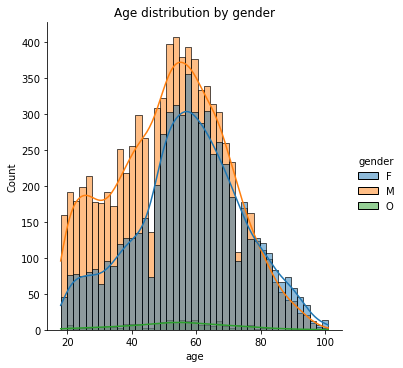

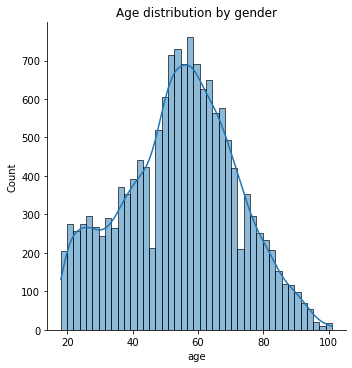

In [134]:
plt.figure(figsize=(10,12))
sns.displot(data=profile, x='age', kde=True, hue= 'gender')
plt.title('Age distribution by gender')

sns.displot(data=profile, x='age', kde=True)
plt.title('Age distribution by gender')


In [ ]:
sns.distplot(profile.age, hist=True, kde=True)
plt.title('Age distribution')

In [100]:
# plot the distribution of categorized age
profile[profile.age==118]['age'] = np.NaN
profile = categorize(profile, 'age', nbins=10, quantiles=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
sum(profile.age==118)

2175

In [98]:
# plot the distribution of categorized age
profile[profile.age==118]['age'] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:
!pip install upgrade sns

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


## Income

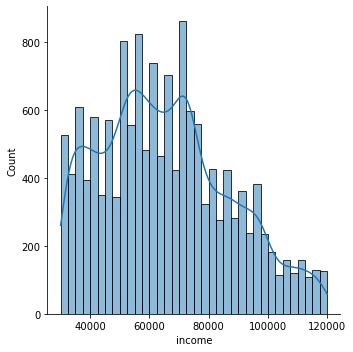

<AxesSubplot:xlabel='income', ylabel='Count'>

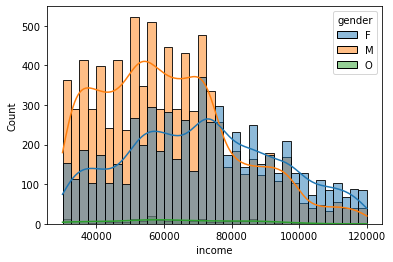

In [148]:
sns.displot(data=profile, x='income', kde=True)
plt.show()
sns.histplot(data=profile, x='income', kde=True, hue = 'gender')

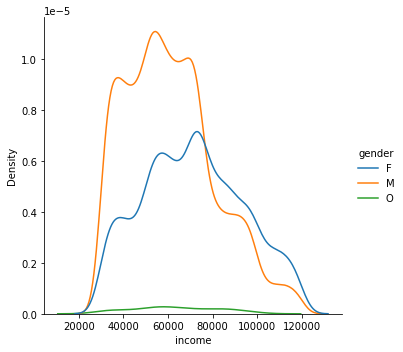

In [151]:
sns.displot(data=profile, x='income', kind='kde', hue = 'gender')

Conclusion: we can observe that woman receive grater income than man

<AxesSubplot:xlabel='gender', ylabel='count'>

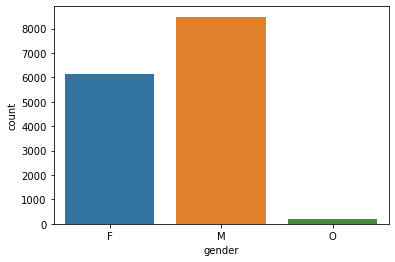

In [154]:
sns.countplot(x='gender', data=profile)

In [159]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m')

In [163]:
new_data = pd.DataFrame([])
new_data['year'] = profile.became_member_on.dt.year
new_data['month'] = profile.became_member_on.dt.month
new_data['day'] = profile.became_member_on.dt.day

In [177]:
monthly_counts = new_data.groupby(['year', 'month']).count().reset_index()

In [181]:
# create dummy variables of channel
monthly_counts['year_month'] = monthly_counts['year'].astype(str)+ '-'+ monthly_counts['month'].astype(str)

In [186]:
monthly_counts.sort_values(['year','month'], inplace=True)

<BarContainer object of 61 artists>

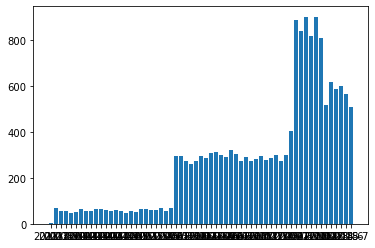

In [187]:
plt.bar(x = monthly_counts.year_month, height = monthly_counts.day)

Conclusion: In general there is increasing trend of the number of new customers over time. However in the recent months there was a drop in the number of new members

## transcript

In [188]:
transcript

,person,event,time,key,val
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,amount,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,amount,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,amount,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,amount,3.53


In [ ]:
# m2[m2.success==1].event.value_counts()

In [ ]:
# split event column
m2[['offer received', 'offer viewed', 'offer completed']] = 0

m2['offer received'] = m2['event'].apply(lambda x: 1 if 'offer received' in x else 0)
m2['offer viewed'] = m2['event'].apply(lambda x: 1 if 'offer viewed' in x else 0)
m2['offer completed'] = m2['event'].apply(lambda x: 1 if 'offer completed' in x else 0)

In [ ]:
m2['web'] = m2['channels'].apply(lambda x: 1 if 'web' in x else 0)
m2['email'] = m2['channels'].apply(lambda x: 1 if 'email' in x else 0)
m2['mobile'] = m2['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
m2['social'] = m2['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [ ]:
m2.drop(labels=['person', 'val', 'event', 'id_x', 'id_y', 'channels'], axis=1)

## which group responds the most to which offer type

In [215]:
data_cat5.head(2)

,person,offer_id,successful,age,id_x,became_member_on,income,age_group_1,age_group_2,age_group_3,...,time_group_1,time_group_2,time_group_3,time_group_4,reward,channels,difficulty,duration,offer_type,id_y
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,...,0,0,0,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
1,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24.0,0020ccbbb6d84e358d3414a3ff76cffd,2016-11-11,60000.0,1,0,0,...,0,0,0,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


In [201]:
# let's analyse which demographic groups (gender, age, income) responded the most to offers given to them

## 1) response to offers overall by gender

In [45]:
# # sex
# # categorize 
# # new_m2 = categorize(m2, 'gender_M', 4)

# # create 
# df_sex_sum = pd.DataFrame(m2.groupby(['gender'])['success'].sum()).reset_index()
# df_sex_count = pd.DataFrame(m2.groupby(['gender'])['success'].count()).reset_index()

# mer = pd.merge(df_sex_sum, df_sex_count, on = ['gender'])
# mer['offer_success_rate'] = mer.success_x/mer.success_y

In [219]:
data_cat5.columns

Index(['person', 'offer_id', 'successful', 'age', 'id_x', 'became_member_on',
       'income', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'income_group_1', 'income_group_2', 'income_group_3', 'income_group_4',
       'gender_group_M', 'gender_group_O', 'time', 'time_group_1',
       'time_group_2', 'time_group_3', 'time_group_4', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type', 'id_y', 'gender'],
      dtype='object')

In [252]:
# send_offers_success_rate by gender and offer_type
df_sex_sum = pd.DataFrame(data_cat5.groupby(['gender'])['successful'].sum()).reset_index()
df_sex_count = pd.DataFrame(data_cat5.groupby(['gender'])['successful'].count()).reset_index()

mer = pd.merge(df_sex_sum, df_sex_count, on = ['gender'])
mer['send_offers_success_rate'] = mer.successful_x/mer.successful_y

In [253]:
mer.sort_values(['gender', 'send_offers_success_rate'])

,gender,successful_x,successful_y,send_offers_success_rate
0,F,10430,16229,0.642677
1,M,14620,22601,0.646874
2,O,406,617,0.658023


Text(0.5, 0, 'gender')

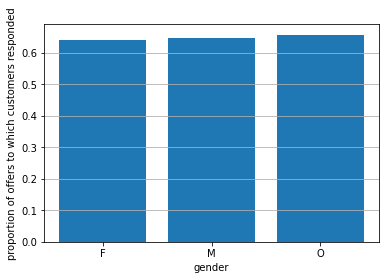

In [256]:
plt.bar(mer.gender, mer.send_offers_success_rate)
plt.grid(axis='y')
plt.ylabel('proportion of offers to which customers responded')
plt.xlabel('gender')

In [227]:
# send_offers_success_rate by gender and offer_type
df_sex_sum = pd.DataFrame(data_cat5.groupby(['gender', 'offer_type'])['successful'].sum()).reset_index()
df_sex_count = pd.DataFrame(data_cat5.groupby(['gender', 'offer_type'])['successful'].count()).reset_index()

mer = pd.merge(df_sex_sum, df_sex_count, on = ['gender', 'offer_type'])
mer['send_offers_success_rate'] = mer.successful_x/mer.successful_y

In [226]:
mer.sort_values(['gender', 'send_offers_success_rate'])

,gender,offer_type,successful_x,successful_y,send_offers_success_rate
0,F,bogo,3575,7001,0.510641
1,F,discount,3835,5850,0.655556
2,F,informational,3020,3378,0.894020
3,M,bogo,4893,9691,0.504901
4,M,discount,5646,8382,0.673586
5,M,informational,4081,4528,0.901281
6,O,bogo,131,243,0.539095
7,O,discount,152,238,0.638655
8,O,informational,123,136,0.904412


In [225]:
# Which offer was the most successful in each group?

mer.groupby('gender')['send_offers_success_rate'].max()

gender
F    0.894020
M    0.901281
O    0.904412
Name: send_offers_success_rate, dtype: float64

In [47]:
# conclusion: 
#     Other type of gender responded the most to the offers send. Men were less likely to respond to the offer received
#     informational offers had the biggest success rate
#     discount offers were on the second place and bogo on the third place regardless of the gender 

## 2) response to offers by age

In [231]:
data_cat5

,person,offer_id,successful,age,id_x,became_member_on,income,age_group_1,age_group_2,age_group_3,...,time_group_2,time_group_3,time_group_4,reward,channels,difficulty,duration,offer_type,id_y,gender
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,...,0,0,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,None
1,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24.0,0020ccbbb6d84e358d3414a3ff76cffd,2016-11-11,60000.0,1,0,0,...,0,0,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,O
2,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55.0,004b041fbfe44859945daa2c7f79ee64,2018-05-08,74000.0,0,0,0,...,0,0,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,O
3,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,1,54.0,004c5799adbf42868b9cff0396190900,2016-03-31,99000.0,0,0,0,...,0,1,0,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,O
4,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d,0,71.0,00857b24b13f4fe0ad17b605f00357f5,2017-10-23,41000.0,0,0,0,...,0,0,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46042,ffc60f10c2444740bc2049712bbffe17,5a8bc65990b245e5a138643cd4eb9837,1,81.0,ffc60f10c2444740bc2049712bbffe17,2018-05-04,65000.0,0,0,0,...,0,0,1,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,F
46043,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,1,67.0,ffeaa02452ef451082a0361c3ca62ef5,2017-02-19,77000.0,0,0,0,...,0,0,1,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,None
46044,ffecb1f8543f4bf7bade023de366d6bf,5a8bc65990b245e5a138643cd4eb9837,1,NaN,ffecb1f8543f4bf7bade023de366d6bf,2017-10-27,NaN,0,0,0,...,0,0,1,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,M
46045,fff3ba4757bd42088c044ca26d73817a,5a8bc65990b245e5a138643cd4eb9837,1,69.0,fff3ba4757bd42088c044ca26d73817a,2015-09-20,83000.0,0,0,0,...,1,0,0,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,F


In [246]:
# age
# categorize 
new_data = categorize(data_cat5, 'age', 4)

# create 
df_age_sum = pd.DataFrame(new_data.groupby(['age_categorized'])['successful'].sum()).reset_index()
df_age_count = pd.DataFrame(new_data.groupby(['age_categorized'])['successful'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['age_categorized'])
mer['offer_success_rate'] = mer.successful_x/mer.successful_y

In [247]:
mer

,age_categorized,successful_x,successful_y,offer_success_rate
0,0,104,168,0.619048
1,1,2266,3777,0.599947
2,2,2699,3987,0.676950
3,3,2834,4153,0.682398
4,4,19805,27362,0.723814


In [ ]:
# Conclusion:
#    older age groups responded to offers more often
 

In [248]:
# bar plot
import matplotlib.pyplot as plt
%matplotlib inline

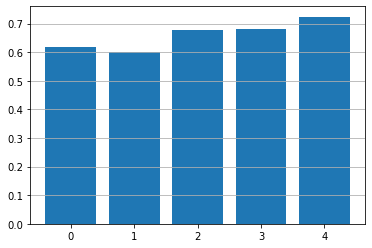

In [250]:
# labels = ['-inf - 18','18 - 32', '32 - 42', '42 -49',  '49 - 54',  '54-inf', 'inf']
plt.bar(mer.age_categorized, mer.offer_success_rate)
# plt.xticks(ticks=[0,1,2,3,4,5,6], labels=labels)
plt.grid(axis='y')

In [56]:
# conclusion: the older are the customers the more they responded to the offer

## 3) income

In [57]:
# # income
# # categorize 
# new_m2 = categorize(m2, 'income', 5, quantiles=True)

# # create 
# df_income_sum = pd.DataFrame(new_m2.groupby(['income_categorized'])['success'].sum()).reset_index()
# df_income_count = pd.DataFrame(new_m2.groupby(['income_categorized'])['success'].count()).reset_index()

# income = pd.merge(df_income_sum, df_income_count, on = ['income_categorized'])
# income['offer_success_rate'] = income.success_x/income.success_y

[  -inf 30000. 37000. 46000. 53000. 58000.    inf]
[0, 1, 2, 3, 4, 5]


In [266]:
# income
# categorize 
new_data = categorize(data_cat5, 'income', 4)

# create 
df_age_sum = pd.DataFrame(new_data.groupby(['income_categorized'])['successful'].sum()).reset_index()
df_age_count = pd.DataFrame(new_data.groupby(['income_categorized'])['successful'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['income_categorized']) 
mer['offer_success_rate'] = mer.successful_x/mer.successful_y

In [267]:
mer

,income_categorized,successful_x,successful_y,offer_success_rate
0,0,112,210,0.533333
1,1,2394,4167,0.574514
2,2,2171,3708,0.585491
3,3,2869,4324,0.663506
4,4,20162,27038,0.745691


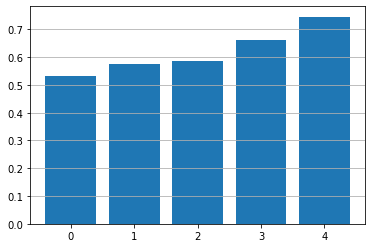

In [268]:
# labels = ['-inf - 30000','30000 - 37000', '37000 - 46000', '46000 -53000',  '53000 - 58000',  '58000-inf', 'inf']
plt.bar(mer.income_categorized, mer.offer_success_rate)
# plt.xticks(ticks=[0,1,2,3,4,5,6],labels=labels, rotation=45)
plt.grid(axis='y')

In [ ]:
# Conclusion:
#     The richer is the group the more they responded to the offers 

# 4) Age and income

In [271]:
# income, age
# categorize 
new_data = categorize(data_cat5, 'age', 4)
new_data = categorize(new_data, 'income', 4)
# create 
df_income_sum = pd.DataFrame(new_data.groupby(['age_categorized', 'income_categorized'])['successful'].sum()).reset_index()
df_income_count = pd.DataFrame(new_data.groupby(['age_categorized', 'income_categorized'])['successful'].count()).reset_index()

df_income_sum.rename(columns={'age_categorized': 'age_s', 'income_categorized': 'income_s', 'successful': 'sum'}, inplace=True)
df_income_count.rename(columns={'age_categorized': 'age_c', 'income_categorized': 'income_c', 'successful': 'count'}, inplace=True)

df_income_sum.rename(columns={'successful': 'sum'})#, axis=columns, inplace=True)
con = pd.concat([df_income_sum, df_income_count], axis=1)

con['offer_success_rate'] = con['sum']/con['count']

In [273]:
new_data.head(2)

,person,offer_id,successful,age,id_x,became_member_on,income,age_group_1,age_group_2,age_group_3,...,time_group_4,reward,channels,difficulty,duration,offer_type,id_y,gender,age_categorized,income_categorized
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,...,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,None,NaN,NaN
1,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24.0,0020ccbbb6d84e358d3414a3ff76cffd,2016-11-11,60000.0,1,0,0,...,1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,O,1,4


<AxesSubplot:xlabel='age_s', ylabel='offer_success_rate'>

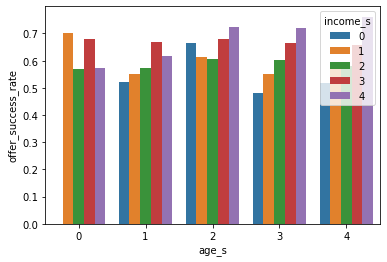

In [274]:
sns.barplot(x='age_s', y = 'offer_success_rate', data=con, hue = 'income_s')

In [276]:
con[['age_s', 'income_s', 'offer_success_rate']].sort_values(['age_s', 'offer_success_rate'])

,age_s,income_s,offer_success_rate
2,0,2,0.568182
4,0,4,0.574074
3,0,3,0.680000
1,0,1,0.700000
0,0,0,NaN
5,1,0,0.522727
6,1,1,0.550995
7,1,2,0.573107
9,1,4,0.616236
8,1,3,0.668529


In [ ]:
# In general in all age groups when income group was bigger the bigger was offer success rate 

In [280]:
data_cat5.columns

Index(['person', 'offer_id', 'successful', 'age', 'id_x', 'became_member_on',
       'income', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'income_group_1', 'income_group_2', 'income_group_3', 'income_group_4',
       'gender_group_M', 'gender_group_O', 'time', 'time_group_1',
       'time_group_2', 'time_group_3', 'time_group_4', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type', 'id_y', 'gender'],
      dtype='object')

## 5) become member on and offer success rate 

In [283]:
# income, age
# categorize 
new_data = categorize(data_cat5, 'time', 4)
# create 
df_income_sum = pd.DataFrame(new_data.groupby(['time_categorized'])['successful'].sum()).reset_index()
df_income_count = pd.DataFrame(new_data.groupby(['time_categorized'])['successful'].count()).reset_index()

df_income_sum.rename(columns={'successful': 'sum'}, inplace=True)
df_income_count.rename(columns={'successful': 'count'}, inplace=True)

# df_income_sum.rename(columns={'successful': 'sum'})#, axis=columns, inplace=True)
con = pd.concat([df_income_sum, df_income_count], axis=1)

con['offer_success_rate'] = con['sum']/con['count']
con

,time_categorized,sum,time_categorized,count,offer_success_rate
0,0,4,0,4,1.000000
1,1,3201,1,4605,0.695114
2,2,3689,2,4611,0.800043
3,3,3732,3,4627,0.806570
4,4,19100,4,32200,0.593168


In [ ]:
# Here it is difficult to find any correlation between time someone spends with the Starbucks and offer success rate

# Some interesting statistics

In [279]:
new_data.columns

Index(['person', 'offer_id', 'successful', 'age', 'id_x', 'became_member_on',
       'income', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'income_group_1', 'income_group_2', 'income_group_3', 'income_group_4',
       'gender_group_M', 'gender_group_O', 'time', 'time_group_1',
       'time_group_2', 'time_group_3', 'time_group_4', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type', 'id_y', 'gender',
       'age_categorized', 'income_categorized'],
      dtype='object')

percentage of web offers: 0.533105880992309
percentage of email offers: 0.4568208334250556
percentage of mobile offers: 0.4514690935969694
percentage of social offers: 0.4696539988655701


Text(0.5, 1.0, 'proportion of all offers')

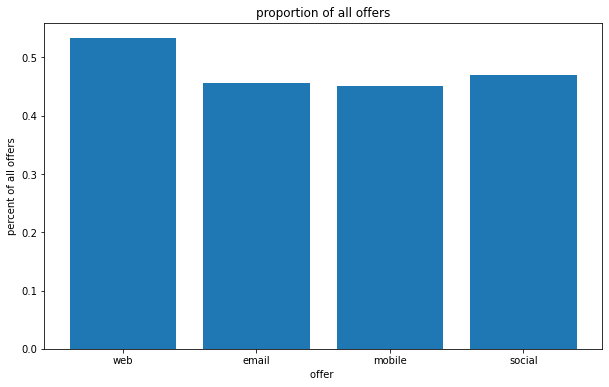

In [99]:
# what is percentage of completed offers in all types of offers
print(f'percentage of web offers: {m2[m2.success==1].web.sum()/m2.web.sum()}')
print(f'percentage of email offers: {m2[m2.success==1].email.sum()/m2.email.sum()}')
print(f'percentage of mobile offers: {m2[m2.success==1].mobile.sum()/m2.mobile.sum()}')
print(f'percentage of social offers: {m2[m2.success==1].social.sum()/m2.social.sum()}')

d = m2[m2.success==1][['web','email', 'mobile', 'social']].sum(axis=0)/m2[['web','email', 'mobile', 'social']].sum(axis=0)
plt.figure(figsize=(10,6))
plt.bar(d.index, d.values)
plt.xlabel('offer ')
plt.ylabel('percent of all offers')
plt.title('proportion of all offers')

# Create a report with offer type success rate and age, gender etc. 

In [113]:
# analyse which offer type was most sucessful in which group

In [114]:
m3 = pd.merge(m1, portfolio, left_on='val', right_on = 'id')

In [115]:
m3.groupby(['offer_type'])['success'].mean()

offer_type
bogo             0.502100
discount         0.659778
informational    0.000000
Name: success, dtype: float64

In [116]:
m3_age = categorize(m3, 'age', 5)
m3_age = categorize(m3_age, 'income', 4)

[-inf  18.  32.  42.  49.  54.  inf]
[0, 1, 2, 3, 4, 5]
[  -inf 30000. 37000. 46000. 53000.    inf]
[0, 1, 2, 3, 4]


In [117]:
m3_age = m3_age[['age_categorized', 'income_categorized', 'offer_type','gender', 'success', 'failure']]

In [118]:
# success rate
d1=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=m3_age.success, aggfunc=sum)
d2=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=1, aggfunc=sum)

In [119]:
# get division of that dataframe - success rate for each offer type and age
d = d1.divide(d2)

In [121]:
# failure rate
d1=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=m3_age.failure, aggfunc=sum)
d2=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=1, aggfunc=sum)
# get division of that dataframe - success rate for each offer type and age
d1.divide(d2)

offer_type                              bogo  discount  informational
age_categorized income_categorized                                   
0               1                   0.333333  0.428571            1.0
                2                   0.764706  0.375000            1.0
                3                   0.481481  0.066667            1.0
                4                   0.714286  0.444444            1.0
1               0                   0.696970  0.333333            1.0
                1                   0.683673  0.336508            1.0
                2                   0.629032  0.356941            1.0
                3                   0.548287  0.253333            1.0
                4                   0.562708  0.347826            1.0
2               0                   0.500000  0.181818            1.0
                1                   0.610224  0.382488            1.0
                2                   0.609756  0.358025            1.0
                3                   0.484472  0.257261            1.0
                4                   0.380483  0.238390            1.0
3               0                   0.615385  0.363636            1.0
                1                   0.648936  0.362319            1.0
                2                   0.639269  0.368750            1.0
                3                   0.456067  0.307339            1.0
                4                   0.372110  0.248294            1.0
4               0                   0.625000  0.833333            1.0
                1                   0.616000  0.351064            1.0
                2                   0.576923  0.333333            1.0
                3                   0.425287  0.293233            1.0
                4                   0.313929  0.226613            1.0
5               0                   0.722222  0.428571            1.0
                1                   0.626308  0.367265            1.0
                2                   0.650218  0.342574            1.0
                3                   0.511111  0.331852            1.0
                4                   0.320671  0.222280            1.0

In [122]:
# add gender
# pd.set_option(display.maxrow,50)
# failure rate
d1=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized, m3_age.gender], columns=m3_age.offer_type, values=m3_age.failure, aggfunc=sum)
d2=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized, m3_age.gender], columns=m3_age.offer_type, values=1, aggfunc=sum)
# get division of that dataframe - success rate for each offer type and age
d1.divide(d2)



offer_type                                     bogo  discount  informational
age_categorized income_categorized gender                                   
0               1                  F       0.200000  1.000000            1.0
                                   M       0.500000  0.333333            NaN
                2                  F       1.000000  0.666667            1.0
                                   M       0.714286  0.307692            1.0
                3                  F       0.833333  0.000000            NaN
...                                             ...       ...            ...
5               3                  M       0.585502  0.341573            1.0
                                   O       0.230769  0.214286            1.0
                4                  F       0.268331  0.193537            1.0
                                   M       0.378441  0.251439            1.0
                                   O       0.255102  0.239583            1.0

[79 rows x 3 columns]